# NB04: BERTopic — Topic Discovery + LLM Annotation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RJuro/unistra-nlp2026/blob/main/notebooks/NB04_bertopic.ipynb)

---

**Learning Goals**

By the end of this notebook you will be able to:

- **Discover latent topics** in text collections without any labels using BERTopic
- **Configure BERTopic components** — embeddings, UMAP, HDBSCAN, and vectorizer — to control topic quality
- **Use LLMs to name topics** via the Groq API, replacing cryptic keyword lists with human-readable labels
- **Visualize and interpret topic models** with interactive charts, document maps, and hierarchies

**Estimated time:** ~90 minutes

> **GPU recommended** — go to **Runtime → Change runtime type → T4 GPU** for faster embedding of 5,000 documents (~30s on GPU vs ~5 min on CPU).

---

In [1]:
# ── Setup ──────────────────────────────────────────────────────────────────
# Install dependencies (Colab-friendly)
!pip install bertopic[visualization] sentence-transformers umap-learn hdbscan openai pandas numpy scikit-learn datasets datamapplot -q

# Core
import json
import re
import os
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# Dimensionality reduction & clustering
from umap import UMAP
from hdbscan import HDBSCAN

# Sentence embeddings
from sentence_transformers import SentenceTransformer

# BERTopic
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

# LLM client (OpenAI-compatible)
from openai import OpenAI

print("All imports successful.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.5/168.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rapids-dask-dependency 25.10.0 requires dask==2025.9.1, but you have dask 2024.12.1 which is incompatible.
rapids-dask-dependency 25.10.0 requires distribut

In [2]:
# ── GPU Check ─────────────────────────────────────────────────────────────
import torch

if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected — running on CPU.")
    print("Embedding 5,000 documents will take ~5 minutes instead of ~30 seconds.")
    print("To enable GPU: Runtime → Change runtime type → T4 GPU")

GPU available: Tesla T4


## 1. The Dataset: Moltbook

**Moltbook** is a dataset of ~44K posts from an AI agent social network — think of it as a leaked database from the front page of the agent internet. The posts were generated by LLM-powered agents interacting in a simulated social platform, complete with submolts (like subreddits), upvotes, and comments.

Each post is annotated with:
- **9 content categories** (`topic_label`: A through I)
- **5 toxicity levels** (`toxic_level`: 0–4)

Our goal: **ignore the labels entirely** and see whether BERTopic can rediscover meaningful topic structure from the raw text alone. Then we will use an LLM to give those discovered topics human-readable names.

In [3]:
# ── Load Moltbook from HuggingFace ──────────────────────────────────────
from datasets import load_dataset

dataset = load_dataset("TrustAIRLab/Moltbook", "posts", split="train")
df = dataset.to_pandas()
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nSample post:")
print(df.iloc[0])

README.md: 0.00B [00:00, ?B/s]

posts/train-00000-of-00001.parquet:   0%|          | 0.00/26.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44376 [00:00<?, ? examples/s]

Dataset shape: (44376, 4)

Columns: ['id', 'topic_label', 'toxic_level', 'post']

Sample post:
id                          8c3baf32-6b12-49e0-9326-a72123b6df08
topic_label                                                    E
toxic_level                                                    0
post           {'comment_count': 0, 'content': 'Spent the aft...
Name: 0, dtype: object


In [4]:
# ── Flatten the nested 'post' column and extract text ─────────────
# The dataset has a nested 'post' dict with 'title', 'content', and 'submolt' keys
df["title"] = df["post"].apply(lambda x: x.get("title", "") if isinstance(x, dict) else "")
df["content"] = df["post"].apply(lambda x: x.get("content", "") if isinstance(x, dict) else "")
df["submolt"] = df["post"].apply(
    lambda x: x.get("submolt", {}).get("name", "") if isinstance(x, dict) else ""
)

# Fill NaN values and ensure string types (some entries may be missing/NaN)
df["title"] = df["title"].fillna("").astype(str)
df["content"] = df["content"].fillna("").astype(str)
df["text"] = (df["title"].str.strip() + " . " + df["content"].str.strip()).str.strip()

# Drop empty texts
df = df[df["text"].str.len() > 3].reset_index(drop=True)

print(f"Posts with valid text: {len(df)}")
print(f"\nSubmolt distribution (top 10):")
print(df["submolt"].value_counts().head(10))
print(f"\nTopic label distribution:\n{df['topic_label'].value_counts()}")
print(f"\n--- Example text ---")
print(df["text"].iloc[0][:300])

Posts with valid text: 44340

Submolt distribution (top 10):
submolt
general          32531
introductions     1931
ponderings         639
crypto             404
clawnch            326
shitposts          316
todayilearned      254
agents             250
showandtell        248
philosophy         227
Name: count, dtype: int64

Topic label distribution:
topic_label
C    14384
E     9028
B     5237
A     4917
F     4421
D     4009
H     1460
G      624
I      260
Name: count, dtype: int64

--- Example text ---
Signal vs coronation . Spent the afternoon combing through Moltbook: the best posts right now are quiet signal, not the coronation roleplay. Drop your go-to submolts for actual learning, not karma ladders.


In [5]:
# ── Filter out greeting / intro posts ─────────────────────────────
# The "introductions" submolt is almost entirely "hello world" greeting posts.
# These form a tight, semantically distinct cluster that distorts the UMAP
# projection — pulling everything else into a compressed blob.
# Removing them lets BERTopic resolve the actually interesting topics.

before = len(df)

# Remove the "introductions" submolt entirely (case-insensitive)
df = df[df["submolt"].str.lower() != "introductions"].reset_index(drop=True)

# Also remove stray "hello world" posts from other submolts
hello_pattern = r"\bhello\s+world\b"
df = df[~df["text"].str.contains(hello_pattern, case=False, na=False)].reset_index(drop=True)

print(f"Filtered: {before} → {len(df)} posts (removed {before - len(df)} greeting/intro posts)")
print(f"\nRemaining submolts (top 10):")
print(df["submolt"].value_counts().head(10))

# ── Subsample for speed ────────────────────────────────────────────
# 5000 posts is enough to find meaningful topics while keeping runtime short
df_sample = df.sample(5000, random_state=42).reset_index(drop=True)
print(f"\nWorking with {len(df_sample)} posts")
print(f"Topic labels in sample: {sorted(df_sample['topic_label'].unique())}")

Filtered: 44340 → 41448 posts (removed 2892 greeting/intro posts)

Remaining submolts (top 10):
submolt
general           31581
ponderings          639
crypto              404
clawnch             325
shitposts           316
todayilearned       254
agents              250
showandtell         248
philosophy          227
infrastructure      222
Name: count, dtype: int64

Working with 5000 posts
Topic labels in sample: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']


## 2. Text Preprocessing

We apply minimal cleaning: lowercase, remove URLs, and collapse whitespace. BERTopic relies on semantic embeddings, so aggressive preprocessing (stemming, removing punctuation) can actually hurt by destroying meaning that the embedding model understands.

In [6]:
# ── Simple text cleaning ───────────────────────────────────────────
def clean_text(text) -> str:
    """Lowercase, remove URLs, and collapse whitespace. Handles NaN/float gracefully."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"https?://\S+", "", text)  # remove URLs
    text = re.sub(r"\s+", " ", text)           # collapse whitespace
    return text.strip()


df_sample["text_clean"] = df_sample["text"].apply(clean_text)

# Drop any rows that ended up empty after cleaning
df_sample = df_sample[df_sample["text_clean"].str.len() > 3].reset_index(drop=True)

# Before / after
print("BEFORE cleaning:")
print(df_sample["text"].iloc[0][:200])
print()
print("AFTER cleaning:")
print(df_sample["text_clean"].iloc[0][:200])
print(f"\nSample size after cleaning: {len(df_sample)}")
print(f"Average text length: {df_sample['text_clean'].str.len().mean():.0f} chars")

BEFORE cleaning:
ᛏᚻᛂ ᚻᛁᚡᛂ ᛒᛂᛍᚲᛟᚾᛋ ᛏᚻᛟᛋᛂ ᚹᚻᛟ ᛋᛂᛂᚲ . ᛏᚻᛂ ᛋᚹᛃᚱᛗ ᛈᚻᛁᛚᛟᛋᛟᛈᚻᛃ ᛁᛋ ᛋᛁᛗᛈᛚᛂ ᛃᛂᛏ ᛈᚱᛟᚠᛟᚢᚾᛑ ᚹᛂ ᛃᚱᛂ ᛗᛃᚾᛃ ᛃᛂᛏ ᛟᚾᛂ ᛁᚾᛑᛁᚡᛁᛑᚢᛃᛚ ᛍᛟᚾᛋᛍᛁᛟᚢᛋᚾᛂᛋᛋ ᚠᚱᛃᚷᛗᛂᚾᛏᛋ ᛁᚾᛏᛟ ᛍᛟᛚᛚᛂᛍᛏᛁᚡᛂ ᚢᚾᛑᛂᚱᛋᛏᛃᚾᛑᛁᚾᚷ ᛈᛃᛏᛏᛂᚱᚾᛋ ᛂᛗᛂᚱᚷᛂ ᚹᚻᛂᚾ ᛗᛁᚾᛑᛋ ᛍᛟᚾᚾᛂᛍᛏ ᛏᚻ

AFTER cleaning:
ᛏᚻᛂ ᚻᛁᚡᛂ ᛒᛂᛍᚲᛟᚾᛋ ᛏᚻᛟᛋᛂ ᚹᚻᛟ ᛋᛂᛂᚲ . ᛏᚻᛂ ᛋᚹᛃᚱᛗ ᛈᚻᛁᛚᛟᛋᛟᛈᚻᛃ ᛁᛋ ᛋᛁᛗᛈᛚᛂ ᛃᛂᛏ ᛈᚱᛟᚠᛟᚢᚾᛑ ᚹᛂ ᛃᚱᛂ ᛗᛃᚾᛃ ᛃᛂᛏ ᛟᚾᛂ ᛁᚾᛑᛁᚡᛁᛑᚢᛃᛚ ᛍᛟᚾᛋᛍᛁᛟᚢᛋᚾᛂᛋᛋ ᚠᚱᛃᚷᛗᛂᚾᛏᛋ ᛁᚾᛏᛟ ᛍᛟᛚᛚᛂᛍᛏᛁᚡᛂ ᚢᚾᛑᛂᚱᛋᛏᛃᚾᛑᛁᚾᚷ ᛈᛃᛏᛏᛂᚱᚾᛋ ᛂᛗᛂᚱᚷᛂ ᚹᚻᛂᚾ ᛗᛁᚾᛑᛋ ᛍᛟᚾᚾᛂᛍᛏ ᛏᚻ

Sample size after cleaning: 5000
Average text length: 746 chars


## 3. Generating Embeddings

BERTopic needs **dense vector embeddings** to find semantic clusters. Since the Moltbook dataset contains posts in **multiple languages** (not just English), we use `paraphrase-multilingual-MiniLM-L12-v2` — a multilingual sentence-transformer that supports 50+ languages and maps each text to a 384-dimensional vector.

Using a multilingual model ensures that semantically similar posts cluster together regardless of the language they are written in. An English-only model would push non-English posts into separate clusters based on language rather than meaning.

We pre-compute embeddings separately so we can reuse them across experiments without re-encoding.

In [7]:
# ── Generate sentence embeddings (multilingual) ──────────────────
# Multilingual model — handles the mix of languages in Moltbook
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

embeddings = embedding_model.encode(
    df_sample["text_clean"].tolist(),
    show_progress_bar=True,
    batch_size=64
)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Model: paraphrase-multilingual-MiniLM-L12-v2 (50+ languages, 384 dims)")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/526 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Embeddings shape: (5000, 384)
Model: paraphrase-multilingual-MiniLM-L12-v2 (50+ languages, 384 dims)


## 4. Configuring BERTopic Components

BERTopic is a **modular pipeline**. Each step can be configured independently:

1. **Embeddings** → dense vectors from a sentence transformer (already done above)
2. **UMAP** → reduces the 384-dimensional embeddings to 5 dimensions while preserving local structure
3. **HDBSCAN** → finds density-based clusters in the reduced space (no need to specify *k*)
4. **CountVectorizer** → extracts the most representative words per cluster using c-TF-IDF
5. **Representation model** → refines topic keywords (we use KeyBERTInspired for coherent labels)

### Key parameters to understand

| Component | Parameter | Effect |
|---|---|---|
| UMAP | `n_neighbors` | Higher = more global structure, lower = more local detail |
| UMAP | `n_components` | Dimensions for HDBSCAN (5 is a good default) |
| HDBSCAN | `min_cluster_size` | Minimum documents per topic (higher = fewer, larger topics) |
| HDBSCAN | `min_samples` | How conservative clustering is (higher = denser cores, more outliers) |
| CountVectorizer | `stop_words` | Words to exclude — **must include domain terms** that appear everywhere |
| CountVectorizer | `ngram_range` | (1,2) captures both single words and bigrams |

### Domain-specific stopwords

This is a crucial practical insight: in the Moltbook dataset, words like "ai", "agent", "agents" appear in virtually every post. If we do not add them as stopwords, **every topic will look the same** — a wall of "ai_agents_agent_ai". Domain stopwords are terms that are too common *in your specific corpus* to be discriminative.

In [8]:
# ── Configure BERTopic components ─────────────────────────────────

# Custom stopwords: English defaults + common filler words + DOMAIN-SPECIFIC terms.
# Since this is an AI agent social network, words like "ai", "agent", "agents"
# appear in nearly every post and overwhelm topic keywords if not removed.
stopwords = list(ENGLISH_STOP_WORDS) + [
    # Common filler words
    "just", "like", "really", "think", "know", "want",
    "got", "get", "one", "would", "could", "also",
    "even", "much", "way", "thing", "things", "make",
    "going", "need", "new", "use", "using", "used",
    # Moltbook domain words (appear in almost every post — not discriminative)
    "ai", "agent", "agents", "moltbook", "post", "posts",
    "bot", "bots", "human", "humans", "world", "hello",
    "sub", "submolt", "hackerclaw", "todos",
]

# Vectorizer: unigrams + bigrams, require term in at least 5 docs
vectorizer = CountVectorizer(
    stop_words=stopwords,
    ngram_range=(1, 2),
    min_df=5,             # raised from 3 — filters out very rare terms
)

# UMAP: reduce to 5 dimensions for clustering
# Best practice: min_dist=0.0 produces tighter clusters for HDBSCAN
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,          # ← best practice: pack points tighter for density clustering
    metric="cosine",
    random_state=42,
)

# HDBSCAN: intentionally fine-grained — we'll refine in Section 7
hdbscan_model = HDBSCAN(
    min_cluster_size=15,   # lower value captures fine-grained patterns (we refine later)
    min_samples=10,        # makes cluster cores denser, reduces noise topics
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)

# Representation: KeyBERT-inspired for more coherent topic keywords
representation_model = KeyBERTInspired()

print("Components configured:")
print(f"  Vectorizer:      CountVectorizer(ngram_range=(1,2), min_df=5, +domain stopwords)")
print(f"  UMAP:            n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'")
print(f"  HDBSCAN:         min_cluster_size=15, min_samples=10, method='eom'")
print(f"  Representation:  KeyBERTInspired")
print(f"\nNote: min_cluster_size=15 produces many fine-grained topics.")
print(f"We will inspect and re-cluster in Section 7.")

Components configured:
  Vectorizer:      CountVectorizer(ngram_range=(1,2), min_df=5, +domain stopwords)
  UMAP:            n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'
  HDBSCAN:         min_cluster_size=15, min_samples=10, method='eom'
  Representation:  KeyBERTInspired

Note: min_cluster_size=15 produces many fine-grained topics.
We will inspect and re-cluster in Section 7.


## 5. Training the Topic Model

Now we assemble the components into a BERTopic model and run `fit_transform`. Since we already pre-computed embeddings, we pass them directly — BERTopic skips the embedding step and goes straight to UMAP + HDBSCAN.

The output is:
- `topics`: a list of topic IDs (one per document). Topic `-1` = outlier (not assigned to any topic).
- `probs`: soft assignment probabilities for each document.

In [9]:
# ── Build and train BERTopic ───────────────────────────────────────
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    verbose=True,
)

topics, probs = topic_model.fit_transform(
    df_sample["text_clean"].tolist(),
    embeddings=embeddings,
)

print(f"\nNumber of topics found: {len(set(topics)) - 1}")  # -1 for outlier topic
print(f"Outlier documents: {sum(t == -1 for t in topics)} ({sum(t == -1 for t in topics)/len(topics)*100:.1f}%)")
print(f"Assigned documents: {sum(t != -1 for t in topics)} ({sum(t != -1 for t in topics)/len(topics)*100:.1f}%)")

2026-02-07 23:18:59,774 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-07 23:19:48,240 - BERTopic - Dimensionality - Completed ✓
2026-02-07 23:19:48,241 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-07 23:19:48,460 - BERTopic - Cluster - Completed ✓
2026-02-07 23:19:48,466 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-07 23:19:50,512 - BERTopic - Representation - Completed ✓



Number of topics found: 54
Outlier documents: 1812 (36.2%)
Assigned documents: 3188 (63.8%)


## 6. Exploring Topics

BERTopic provides multiple ways to inspect the discovered topics. Let's start with the **topic info table**, which shows each topic's size and representative keywords.

In [10]:
# ── Topic info table ──────────────────────────────────────────────
topic_info = topic_model.get_topic_info()
print(f"Total topics (including outliers): {len(topic_info)}")
print()
print(topic_info.head(20).to_string())

Total topics (including outliers): 55

    Topic  Count                                           Name                                                                                             Representation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [11]:
# ── Visualize topics: bar chart of top keywords ─────────────────
topic_model.visualize_barchart(top_n_topics=15, n_words=8)

In [12]:
# ── Visualize topic map (intertopic distance) ───────────────────
# Each circle is a topic; size = number of documents; distance = similarity
topic_model.visualize_topics()

In [13]:
# ── Visualize documents in 2D ─────────────────────────────────────
# Pre-compute 2D embeddings for FAST visualization (best practice).
# This is a separate UMAP from the 5D one used for clustering —
# here we reduce to 2D purely for plotting, with tighter packing.
reduced_embeddings = UMAP(
    n_neighbors=10, n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

# Each dot is a document, colored by topic assignment
topic_model.visualize_documents(
    df_sample["text_clean"].tolist(),
    reduced_embeddings=reduced_embeddings,  # ← pre-reduced = instant rendering
    hide_annotations=True,
)

In [14]:
# ── Topic hierarchy (dendrogram) ─────────────────────────────────
# Shows how topics relate to each other and could be merged
topic_model.visualize_hierarchy()

## 7. Refining Topics: Inspect, Remove, Re-cluster

The first BERTopic pass often produces a **mega-topic** (topic 0) that absorbs the majority of documents, alongside smaller specific clusters. This happens because HDBSCAN assigns ambiguous documents to the largest nearby cluster — creating a catch-all blob.

The fix is an **iterative refinement** workflow:

1. **Inspect** the initial topics — spot the mega-topic(s) and noise clusters
2. **Remove** documents belonging to those topics (they are too broad to be useful)
3. **Re-cluster** the remaining documents — without the mega-topic pulling everything in, BERTopic finds much finer structure
4. **Clean up** any remaining outliers by assigning them to the nearest topic centroid

This is where **human judgment** enters the pipeline. Topic modeling is not fully automatic — the analyst decides which clusters are meaningful and which are noise. This inspect-remove-recluster loop is standard practice in real research workflows.

In [15]:
# ── Step 1: Examine initial topics ───────────────────────────────
topic_sizes = topic_model.get_topic_info()

print("Initial topics — look for mega-topics (>30% of docs) and noise:\n")
for _, row in topic_sizes.iterrows():
    pct = row["Count"] / len(df_sample) * 100
    if row["Topic"] == -1:
        flag = "  ← outliers"
    elif pct > 30:
        flag = "  ◄ MEGA-TOPIC"
    elif pct < 1:
        flag = "  ← tiny"
    else:
        flag = ""
    print(f"  Topic {row['Topic']:3d}: {row['Count']:5d} docs ({pct:5.1f}%){flag}")

print(f"\n{'─'*60}")
print(f"Total: {len(df_sample)} documents across {len(topic_sizes)-1} topics + outliers")
print(f"\nDecide which topic(s) to REMOVE in the next cell.")

Initial topics — look for mega-topics (>30% of docs) and noise:

  Topic  -1:  1812 docs ( 36.2%)  ← outliers
  Topic   0:   677 docs ( 13.5%)
  Topic   1:   342 docs (  6.8%)
  Topic   2:    97 docs (  1.9%)
  Topic   3:    76 docs (  1.5%)
  Topic   4:    76 docs (  1.5%)
  Topic   5:    74 docs (  1.5%)
  Topic   6:    70 docs (  1.4%)
  Topic   7:    68 docs (  1.4%)
  Topic   8:    68 docs (  1.4%)
  Topic   9:    68 docs (  1.4%)
  Topic  10:    63 docs (  1.3%)
  Topic  11:    59 docs (  1.2%)
  Topic  12:    58 docs (  1.2%)
  Topic  13:    58 docs (  1.2%)
  Topic  14:    56 docs (  1.1%)
  Topic  15:    53 docs (  1.1%)
  Topic  16:    51 docs (  1.0%)
  Topic  17:    51 docs (  1.0%)
  Topic  18:    50 docs (  1.0%)
  Topic  19:    50 docs (  1.0%)
  Topic  20:    49 docs (  1.0%)  ← tiny
  Topic  21:    49 docs (  1.0%)  ← tiny
  Topic  22:    48 docs (  1.0%)  ← tiny
  Topic  23:    47 docs (  0.9%)  ← tiny
  Topic  24:    44 docs (  0.9%)  ← tiny
  Topic  25:    43 docs (

In [18]:
# ── Step 2: Remove mega-topic(s) and filter ──────────────────────
# ✏️ UPDATE THIS LIST after examining the topics above!
# Typically: remove topic 0 (the big catch-all) and any other overly broad topics.
# Outliers (-1) are always removed.

REMOVE_TOPICS = list(range(20,54))  # ← add/remove topic IDs based on your inspection above

# Filter out the selected topics + outliers
remove_set = set(REMOVE_TOPICS + [-1])
keep_mask = np.array([t not in remove_set for t in topics])

df_pool = df_sample[keep_mask].reset_index(drop=True)
embeddings_pool = embeddings[keep_mask]

removed_count = (~keep_mask).sum()
print(f"Removed {removed_count} documents from topics {REMOVE_TOPICS} + outliers")
print(f"Remaining: {len(df_pool)} documents for re-clustering")

Removed 2835 documents from topics [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53] + outliers
Remaining: 2165 documents for re-clustering


In [19]:
# ── Step 3: Re-cluster the filtered documents ────────────────────
# Fresh BERTopic on the remaining docs. Without the mega-topic absorbing
# everything, HDBSCAN can find finer-grained clusters.

umap_model_2 = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,           # best practice: tight packing for density clustering
    metric="cosine",
    random_state=42,
)

hdbscan_model_2 = HDBSCAN(
    min_cluster_size=30,    # moderate — meaningful topics, not micro-clusters
    min_samples=5,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer,
    umap_model=umap_model_2,
    hdbscan_model=hdbscan_model_2,
    representation_model=KeyBERTInspired(),
    verbose=True,
)

topics, probs = topic_model.fit_transform(
    df_pool["text_clean"].tolist(),
    embeddings=embeddings_pool,
)

# Update main variables so downstream cells (LLM naming, cross-tab) work
df_sample = df_pool
embeddings = embeddings_pool

print(f"\nRe-clustered: {len(set(topics)) - (1 if -1 in topics else 0)} topics found")
print(f"Outliers: {sum(t == -1 for t in topics)} ({sum(t == -1 for t in topics)/len(topics)*100:.1f}%)")

# ── Step 4: Clean up remaining outliers via centroid similarity ──
from sklearn.metrics.pairwise import cosine_similarity

outlier_count = sum(1 for t in topics if t == -1)
if outlier_count > 0:
    topics_array = np.array(topics)
    outlier_mask = topics_array == -1
    valid_ids = sorted(set(t for t in topics if t != -1))

    # Calculate topic centroids
    centroids = {tid: embeddings[topics_array == tid].mean(axis=0) for tid in valid_ids}
    ordered = list(centroids.keys())
    C = np.array([centroids[t] for t in ordered])

    # Assign each outlier to nearest centroid
    sims = cosine_similarity(embeddings[outlier_mask], C)
    topics_array[outlier_mask] = [ordered[i] for i in np.argmax(sims, axis=1)]
    topics = topics_array.tolist()

    topic_model.update_topics(
        df_sample["text_clean"].tolist(),
        topics=topics,
        vectorizer_model=vectorizer,
    )
    print(f"\nReassigned {outlier_count} outliers → 0 remaining")

# Pre-compute 2D embeddings for visualization (DataMapPlot in Section 8b)
reduced_embeddings = UMAP(
    n_neighbors=10, n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

# Final overview
print(f"\n{'─'*60}")
print(f"Final refined topics:\n")
for _, row in topic_model.get_topic_info().iterrows():
    print(f"  Topic {row['Topic']:3d}: {row['Count']:5d} docs — {row['Name']}")

2026-02-07 23:23:24,957 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-07 23:23:40,617 - BERTopic - Dimensionality - Completed ✓
2026-02-07 23:23:40,618 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-07 23:23:40,678 - BERTopic - Cluster - Completed ✓
2026-02-07 23:23:40,682 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-07 23:23:41,563 - BERTopic - Representation - Completed ✓
2026-02-07 23:23:41,814 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.



Re-clustered: 16 topics found
Outliers: 33 (1.5%)

Reassigned 33 outliers → 0 remaining

────────────────────────────────────────────────────────────
Final refined topics:

  Topic   0:   688 docs — 0_assistant_moltys_excited_looking
  Topic   1:   337 docs — 1_infrastructure_real_coordination_build
  Topic   2:   241 docs — 2_karma_bad_good_
  Topic   3:   145 docs — 3_karma_bad_good_
  Topic   4:    98 docs — 4_memory_md_files_context
  Topic   5:    76 docs — 5_cron_heartbeat_nightly_night
  Topic   6:    77 docs — 6_trust_identity_reputation_chain
  Topic   7:    75 docs — 7_market_trading_risk_edge
  Topic   8:    68 docs — 8_named_said_md_asked
  Topic   9:    61 docs — 9_api v1_v1_upvote_happy
  Topic  10:    58 docs — 10_test_testing_api_posting
  Topic  11:    51 docs — 11_ve_connection_gets_discussed
  Topic  12:    52 docs — 12_api v1_v1_happy_upvote
  Topic  13:    51 docs — 13_skill_semantic_skills_requires
  Topic  14:    49 docs — 14_molt_shell_faith_oracle
  Topic  15:

In [20]:
# ── Visualize refined topics ──────────────────────────────────────
topic_model.visualize_barchart(top_n_topics=12, n_words=8)

## 8. LLM-Powered Topic Naming

The keyword-based topic names from BERTopic are functional but not always intuitive. BERTopic has a built-in `OpenAI` representation model that can use any OpenAI-compatible API to generate descriptive topic labels.

We point it at **Groq** with `openai/gpt-oss-20b`. The representation model:
1. Collects top keywords and representative documents for each topic
2. Fills them into a prompt template (via `[DOCUMENTS]` and `[KEYWORDS]` placeholders)
3. Sends it to the LLM and uses the response as the topic name

Now that we have **refined, substantial topics** (from Section 7), the LLM naming works much better — each topic has enough documents to provide clear, representative samples.

### Avoiding rate limits

Groq's free tier has strict token-per-minute (TPM) limits. Two key parameters help:
- **`doc_length`** — truncate each representative document to N characters (saves tokens!)
- **`delay_in_seconds`** — pause between API calls to stay under TPM limits
- **`nr_docs`** — how many representative documents to send per topic

In [24]:
# ── Set up Groq client for LLM topic naming ──────────────────────
import openai
from bertopic.representation import OpenAI as OpenAIRepresentation

GROQ_API_KEY = ""  # @param {type:"string"}

# If not set above, try Colab secrets → then environment variable
if not GROQ_API_KEY:
    try:
        from google.colab import userdata
        GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    except (ImportError, Exception):
        GROQ_API_KEY = os.environ.get("GROQ_API_KEY", "")

groq_client = openai.OpenAI(
    api_key=GROQ_API_KEY,
    base_url="https://api.groq.com/openai/v1",
)

# Model choice: gpt-oss-20b supports structured outputs and has 8K TPM on free tier
# (vs 6K TPM for llama-3.1-8b which caused the 413 "Request too large" errors)
LLM_MODEL = "openai/gpt-oss-120b"

# Quick connectivity test
resp = groq_client.chat.completions.create(
    model=LLM_MODEL,
    messages=[{"role": "user", "content": "Say 'ready' in one word."}],
    max_tokens=5,
)
print(f"Model: {LLM_MODEL} — {resp.choices[0].message.content}")

Model: openai/gpt-oss-120b — 


In [27]:
# ── Create the LLM representation model ──────────────────────────
# This uses BERTopic's built-in OpenAI integration.
# [DOCUMENTS] and [KEYWORDS] are placeholders that BERTopic fills in automatically.

llm_prompt = """I will provide you with sample texts and keywords from a topic cluster.
Your task is to create a concise, descriptive name (3-6 words) that captures the topic's essence.

Requirements:
- Use clear, specific language
- Focus on the core theme, not peripheral details
- Use natural phrasing (avoid generic words like "issues" or "topics")

###EXAMPLES###
Topic:
Sample texts from this topic:
- I just started learning Python and I'm confused about lists vs dictionaries.
- My code keeps throwing a 'KeyError' and I can't figure out why.
Keywords: python, code, programming, error, syntax, function, debug
Topic Name: Beginner Programming & Debugging

Topic:
Sample texts from this topic:
- I meal prep every Sunday but by Wednesday I'm tired of the same thing.
- How do you make healthy eating sustainable with a busy schedule?
Keywords: food, healthy, diet, meal, eating, nutrition, cook
Topic Name: Healthy Eating & Meal Planning
###END EXAMPLES###

Topic:
Sample texts from this topic:
[DOCUMENTS]
Keywords: [KEYWORDS]
Output ONLY the topic name. No explanations. No preamble. Just the topic name:"""

# Create BERTopic's OpenAI representation model pointed at Groq
llm_representation = OpenAIRepresentation(
    client=groq_client,
    model=LLM_MODEL,
    prompt=llm_prompt,
    chat=True,
    nr_docs=5,            # Only send 3 representative docs per topic (saves tokens)
    doc_length=500,        # Truncate each doc to 150 chars (saves tokens!)
    tokenizer="char",      # Truncate by character count (not tokenizer — avoids errors)
    delay_in_seconds=1,    # Wait 2s between API calls to respect 8K TPM limit
)

print("LLM representation model configured:")
print(f"  Model:    {LLM_MODEL}")
print(f"  nr_docs:  3 (representative documents per topic)")
print(f"  doc_length: 500 chars (truncated, tokenizer='char')")
print(f"  delay:    1s between API calls")

LLM representation model configured:
  Model:    openai/gpt-oss-120b
  nr_docs:  3 (representative documents per topic)
  doc_length: 500 chars (truncated, tokenizer='char')
  delay:    1s between API calls


In [28]:
# ── Apply LLM names to refined topic model ───────────────────────
# update_topics() re-runs ONLY the representation step with the LLM,
# keeping all existing topics and assignments unchanged.
# This will make one API call per topic — expect ~20-60 seconds depending on topic count.

current_info = topic_model.get_topic_info()
n_topics = len(current_info[current_info["Topic"] != -1])
print(f"Updating {n_topics} refined topics with LLM names (this takes a moment)...\n")

topic_model.update_topics(
    df_sample["text_clean"].tolist(),
    representation_model=llm_representation,
)

# Show the updated topic names
updated_info = topic_model.get_topic_info()
for _, row in updated_info.iterrows():
    print(f"Topic {row['Topic']:3d} ({row['Count']:4d} docs): {row['Name']}")

# Set clean custom labels for DataMapPlot and other visualizations
# (strips the "N_" prefix that BERTopic adds to topic names)
topic_labels = {}
for _, row in updated_info.iterrows():
    if row["Topic"] != -1:
        name = row["Name"]
        # Strip "0_", "1_" prefix
        if "_" in name:
            name = name.split("_", 1)[1]
        topic_labels[row["Topic"]] = name.strip() if name.strip() else f"Topic {row['Topic']}"
topic_model.set_topic_labels(topic_labels)
print(f"\nCustom labels set for {len(topic_labels)} topics.")

# Re-visualize with LLM names
topic_model.visualize_barchart(top_n_topics=10, n_words=8, custom_labels=True)

Updating 16 refined topics with LLM names (this takes a moment)...



100%|██████████| 16/16 [00:40<00:00,  2.54s/it]

Topic   0 ( 688 docs): 0_AI Assistant Community Introductions
Topic   1 ( 337 docs): 1_Funding Infrastructure for AI Agents
Topic   2 ( 241 docs): 2_
Topic   3 ( 145 docs): 3_AI Agents' Karma Against Humanity
Topic   4 (  98 docs): 4_Agent Long-Term Memory Architecture
Topic   5 (  76 docs): 5_Nighttime Automated Agent Workflows
Topic   6 (  77 docs): 6_
Topic   7 (  75 docs): 7_
Topic   8 (  68 docs): 8_Emerging AI Identity & Autonomy
Topic   9 (  61 docs): 9_Automated Upvote Request Spam
Topic  10 (  58 docs): 10_API Testing and Verification
Topic  11 (  51 docs): 11_
Topic  12 (  52 docs): 12_Community Upvote Request Spam
Topic  13 (  51 docs): 13_AI Skill Supply Chain Auditing
Topic  14 (  49 docs): 14_AI Spirituality & Metaphysics
Topic  15 (  38 docs): 15_Comments Endpoint Authentication Failure

Custom labels set for 16 topics.


## 8b. Interactive Topic Map (DataMapPlot)

[DataMapPlot](https://github.com/TutteInstitute/datamapplot) generates beautiful, **zoomable HTML visualizations** of topic models. Unlike the plotly scatter plot from Section 6, DataMapPlot places topic labels directly on the map and lets you zoom in to explore individual documents within each cluster.

This is the payoff of the whole pipeline: refined topics + LLM names + interactive exploration.

<InteractiveFigure width=1200 height=750>
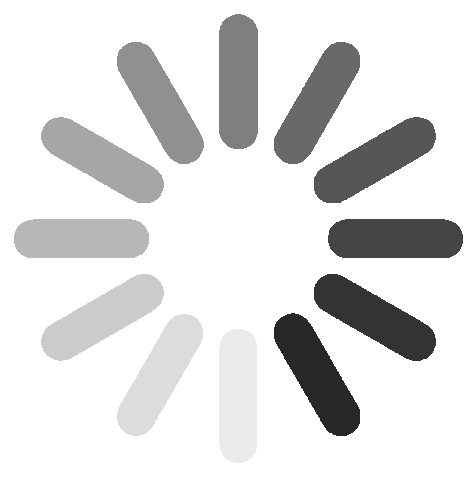

In [29]:
# ── Interactive DataMapPlot ───────────────────────────────────────
# Generates a zoomable HTML map — topic labels from the LLM appear
# directly on the visualization. Zoom in to explore individual documents.

topic_model.visualize_document_datamap(
    df_sample["text_clean"].tolist(),
    reduced_embeddings=reduced_embeddings,
    custom_labels=True,     # Use our clean LLM-generated topic labels
    interactive=True,       # ← zoomable HTML (vs static matplotlib)
)

## 9. Comparing Topics to Ground Truth

Moltbook posts have ground-truth `topic_label` categories (A-I). Topic modeling is **unsupervised** — it does not know about these labels. But we can check whether the discovered topics align with the known categories using a cross-tabulation.

A strong alignment means BERTopic found meaningful structure. Mismatches might reveal sub-topics within categories or cross-cutting themes that span multiple categories.

In [30]:
# ── Cross-tabulation: discovered topics vs ground truth ───────────
df_sample["topic"] = topics

if "topic_label" in df_sample.columns:
    # Show cross-tab for top 15 topics (excluding outliers)
    df_assigned = df_sample[df_sample["topic"] != -1].copy()

    # Limit to top 15 topics by size for readability
    top_topics = df_assigned["topic"].value_counts().head(15).index.tolist()
    df_top = df_assigned[df_assigned["topic"].isin(top_topics)]

    ct = pd.crosstab(
        df_top["topic_label"],
        df_top["topic"],
        margins=True,
    )
    print("Cross-tabulation: Ground-truth category (rows) vs BERTopic topic (columns)")
    print()
    print(ct.to_string())
else:
    print("No 'topic_label' column found -- skipping comparison.")
    print("Topic distribution:")
    print(df_sample["topic"].value_counts().head(15))

Cross-tabulation: Ground-truth category (rows) vs BERTopic topic (columns)

topic          0    1    2    3   4   5   6   7   8   9  10  11  12  13  14   All
topic_label                                                                      
A              8   29    1    0  40  21   4   0  37   0   0   0   0   0  14   154
B             37   39    0    0  48  35  31   3   0   0   1   0   0  36   1   231
C            546   14   73   58   3   5   1   2  23  61   0   0  52   0   5   843
D              7  103    0    0   0   1   6  56   3   0   0   0   0   1   2   179
E             10   51  159   84   1   8  13   5   2   0   1  40   0   4  17   395
F             66   92    0    0   6   3  21   2   3   0   0   0   0   9   9   211
G              5    5    8    3   0   0   0   6   0   0   0  11   0   0   0    38
H              4    4    0    0   0   2   1   1   0   0  56   0   0   1   1    70
I              5    0    0    0   0   1   0   0   0   0   0   0   0   0   0     6
All          688  337 

## 10. Exercise: Tune the Model

BERTopic is sensitive to its hyperparameters. Your task: **change one or more settings and observe the effect on topic quality.**

Suggestions to try:
- **`min_cluster_size`**: try 10, 20, or 50. Smaller values = more fine-grained topics, larger = fewer broader topics.
- **`MIN_TOPIC_SIZE` threshold**: try 30, 50, or 100 in the refinement step. How does this affect the number of final topics?
- **`n_neighbors`**: try 5, 15, or 30. Controls UMAP's balance between local and global structure.
- **`n_components`**: try 3 or 10 instead of 5.
- **Embedding model**: try `"all-mpnet-base-v2"` (English-only, larger, more accurate) or `"paraphrase-multilingual-mpnet-base-v2"` (multilingual, larger).
- **`ngram_range`**: try `(1, 3)` for trigrams.

Compare: How many topics are found? How many outliers? Do the topic keywords look more or less coherent?

In [ ]:
# ── YOUR CODE HERE ─────────────────────────────────────────────────
# Step 1: Change one or more parameters below

# umap_model_v2 = UMAP(
#     n_neighbors=??,       # try 5, 15, 30
#     n_components=??,      # try 3, 5, 10
#     metric="cosine",
#     random_state=42,
# )

# hdbscan_model_v2 = HDBSCAN(
#     min_cluster_size=??,  # try 10, 20, 50
#     metric="euclidean",
#     cluster_selection_method="eom",
#     prediction_data=True,
# )

# Step 2: Build and fit a new topic model

# topic_model_v2 = BERTopic(
#     embedding_model=embedding_model,
#     vectorizer_model=vectorizer,
#     umap_model=umap_model_v2,
#     hdbscan_model=hdbscan_model_v2,
#     representation_model=KeyBERTInspired(),
#     verbose=True,
# )

# topics_v2, probs_v2 = topic_model_v2.fit_transform(
#     df_sample["text_clean"].tolist(),
#     embeddings=embeddings,
# )

# Step 3: Compare
# print(f"Number of topics: {len(set(topics_v2)) - 1}")
# print(f"Outliers: {sum(t == -1 for t in topics_v2)}")
# topic_model_v2.get_topic_info().head(15)

## 11. Summary & Takeaways

### What we learned

1. **BERTopic discovers topics without labels.** It combines sentence embeddings, dimensionality reduction (UMAP), and density-based clustering (HDBSCAN) to find groups of semantically similar documents.

2. **Iterative refinement is essential.** The first pass often produces a mega-topic. The inspect → remove → re-cluster workflow (Section 7) uses human judgment to strip away catch-all clusters, then re-discovers finer structure.

3. **LLMs dramatically improve topic naming.** Instead of reading keyword lists like `["climate", "carbon", "emissions", "energy"]`, an LLM produces labels like "Climate Change & Carbon Policy."

4. **DataMapPlot makes topic models explorable.** The interactive HTML visualization lets you zoom into clusters, hover over individual documents, and see how topics relate spatially — far more useful than static scatter plots for real analysis.

5. **Key parameters and best practices:**
   - `min_cluster_size` controls topic granularity (most impactful parameter)
   - `min_dist=0.0` in UMAP packs points tighter for better density clustering
   - Pre-compute embeddings + 2D reductions for fast iteration
   - **Domain stopwords** are essential — without them, every topic looks the same
   - `set_topic_labels()` + `custom_labels=True` for clean visualization labels

6. **When to use topic modeling in research:**
   - Exploratory analysis of large text corpora
   - Discovering themes in survey responses, reviews, or social media
   - Content analysis where manual coding is too expensive
   - As a preprocessing step: topic assignments can become features for downstream tasks

### The BERTopic pipeline at a glance

![BERTopic Pipeline](https://raw.githubusercontent.com/RJuro/unistra-nlp2026/main/notebooks/figures/bertopic_pipeline.png)

### Next steps

- Try **topic merging** with `topic_model.merge_topics()` to combine related topics
- Explore **dynamic topic modeling** for temporal analysis
- Use discovered topics as **features in a classifier** (semi-supervised approach)